In [1]:
pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=a6639dd5705721bf9c80eca2fd1ec58f94b0529bc991148626205b739344df5a
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 103.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 29.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.33.1
    Uninstalling huggingface-hub-0.33.1:
      Successfully uninstalled huggingface-hub-0.33.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.5.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import ast
from transformers import pipeline
from seqeval.metrics import classification_report

df = pd.read_csv("/kaggle/input/my-data/NER_Dataset.csv")
df["Words"] = df["Word"].apply(ast.literal_eval)
df["Tags"] = df["Tag"].apply(ast.literal_eval)

2025-08-14 18:22:42.807772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755195763.046665      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755195763.119362      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
df = df.drop(columns=["Sentence_ID", "Word", "POS", "Tag"], errors="ignore")

In [5]:
df 

,Words,Tags
0,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo..."
1,"[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,..."
2,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O..."
3,"[They, left, after, a, tense, hour-long, stand...","[O, O, O, O, O, O, O, O, O, O, O]"
4,"[U.N., relief, coordinator, Jan, Egeland, said...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo..."
...,...,...
47954,"[Opposition, leader, Mir, Hossein, Mousavi, ha...","[O, O, O, B-per, I-per, O, O, O, O, O, O, O, O..."
47955,"[On, Thursday, ,, Iranian, state, media, publi...","[O, B-tim, O, B-gpe, O, O, O, O, O, O, O, O, B..."
47956,"[Following, Iran, 's, disputed, June, 12, elec...","[O, B-geo, O, O, B-tim, I-tim, O, O, O, O, O, ..."
47957,"[Since, then, ,, authorities, have, held, publ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [6]:
from collections import Counter
all_tags = [tag for tags in df["Tags"] for tag in tags]

tag_counts = Counter(all_tags)

tag_df = pd.DataFrame(tag_counts.items(), columns=["Tag", "Count"]).sort_values(by="Count", ascending=False)

print(tag_df)

      Tag   Count
0       O  887908
1   B-geo   37644
3   B-tim   20333
4   B-org   20143
7   I-per   17251
6   B-per   16990
8   I-org   16784
2   B-gpe   15870
5   I-geo    7414
9   I-tim    6528
10  B-art     402
15  B-eve     308
11  I-art     297
16  I-eve     253
12  B-nat     201
13  I-gpe     198
14  I-nat      51


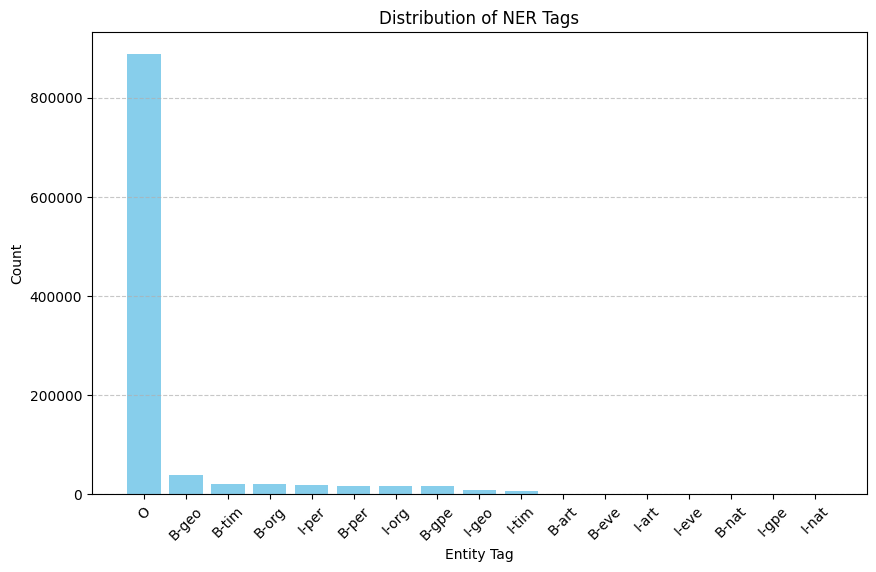

In [7]:
import matplotlib.pyplot as plt
sorted_tags = dict(sorted(tag_counts.items(), key=lambda x: x[1], reverse=True))

# Plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_tags.keys(), sorted_tags.values(), color="skyblue")
plt.xlabel("Entity Tag")
plt.ylabel("Count")
plt.title("Distribution of NER Tags")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [8]:
target_entities = {"B-per", "I-per", "B-org", "I-org"}

o_count_in_target_sentences = 0
total_o_count = 0

for tags in df["Tags"]:
    total_o_count += tags.count("O")
    if any(tag in target_entities for tag in tags):
        o_count_in_target_sentences += tags.count("O")

print(f"Total 'O' tags in dataset: {total_o_count}")
print(f"'O' tags in sentences containing PER or ORG: {o_count_in_target_sentences}")
print(f"Percentage of 'O' in those sentences: {o_count_in_target_sentences / total_o_count * 100:.2f}%")

Total 'O' tags in dataset: 887908
'O' tags in sentences containing PER or ORG: 461627
Percentage of 'O' in those sentences: 51.99%


In [9]:
allowed_tags = {"B-per", "I-per", "B-org", "I-org"}
df["Tags"] = df["Tags"].apply(lambda tags: [tag if tag in allowed_tags else "O" for tag in tags])


In [10]:
from collections import Counter
all_tags = [tag for tags in df["Tags"] for tag in tags]

tag_counts = Counter(all_tags)

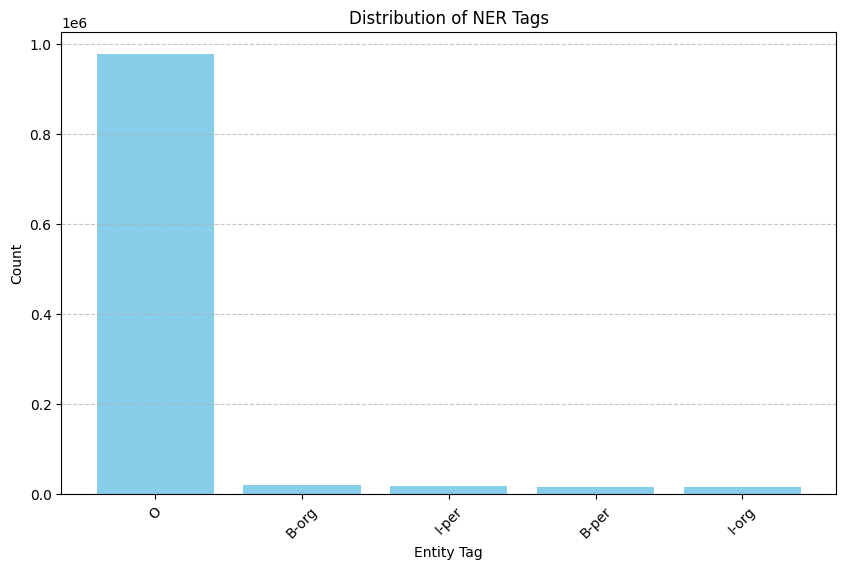

In [11]:
import matplotlib.pyplot as plt
sorted_tags = dict(sorted(tag_counts.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(10, 6))
plt.bar(sorted_tags.keys(), sorted_tags.values(), color="skyblue")
plt.xlabel("Entity Tag")
plt.ylabel("Count")
plt.title("Distribution of NER Tags")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [12]:
sorted_tags

{'O': 977407, 'B-org': 20143, 'I-per': 17251, 'B-per': 16990, 'I-org': 16784}

In [13]:
df

,Words,Tags
0,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,"[Iranian, officials, say, they, expect, to, ge...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-o..."
3,"[They, left, after, a, tense, hour-long, stand...","[O, O, O, O, O, O, O, O, O, O, O]"
4,"[U.N., relief, coordinator, Jan, Egeland, said...","[O, O, O, B-per, I-per, O, O, O, O, O, O, O, O..."
...,...,...
47954,"[Opposition, leader, Mir, Hossein, Mousavi, ha...","[O, O, O, B-per, I-per, O, O, O, O, O, O, O, O..."
47955,"[On, Thursday, ,, Iranian, state, media, publi...","[O, O, O, O, O, O, O, O, O, O, O, O, B-org, I-..."
47956,"[Following, Iran, 's, disputed, June, 12, elec...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
47957,"[Since, then, ,, authorities, have, held, publ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [14]:
target_entities = {"B-per", "I-per", "B-org", "I-org"}

filtered_df = df[df["Tags"].apply(lambda tags: any(tag in target_entities for tag in tags))].copy()

print(f"Original dataset size: {len(df)} sentences")
print(f"Filtered dataset size: {len(filtered_df)} sentences")

filtered_df.head()

Original dataset size: 47959 sentences
Filtered dataset size: 24354 sentences


,Words,Tags
1,"[Iranian, officials, say, they, expect, to, ge...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-o..."
4,"[U.N., relief, coordinator, Jan, Egeland, said...","[O, O, O, B-per, I-per, O, O, O, O, O, O, O, O..."
5,"[Mr., Egeland, said, the, latest, figures, sho...","[B-per, I-per, O, O, O, O, O, O, O, O, O, O, O..."
10,"[In, Beirut, ,, a, string, of, officials, voic...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-o..."


In [15]:
from collections import Counter
all_tags_f = [tag for tags in filtered_df["Tags"] for tag in tags]

tag_counts_f = Counter(all_tags_f)

In [16]:
tag_counts_f

Counter({'O': 509209,
         'B-org': 20143,
         'B-per': 16990,
         'I-per': 17251,
         'I-org': 16784})

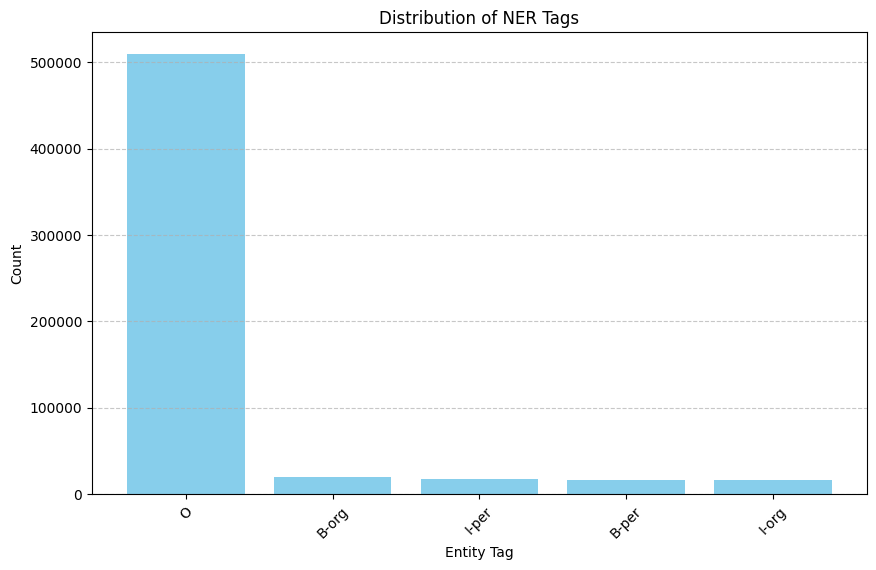

In [17]:
import matplotlib.pyplot as plt
sorted_tags_f = dict(sorted(tag_counts_f.items(), key=lambda x: x[1], reverse=True))

# Plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_tags_f.keys(), sorted_tags_f.values(), color="skyblue")
plt.xlabel("Entity Tag")
plt.ylabel("Count")
plt.title("Distribution of NER Tags")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [18]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(filtered_df, test_size=0.2, random_state=42, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, shuffle=True)

print(f"Train size: {len(train_df)} sentences")
print(f"Validation size: {len(val_df)} sentences")
print(f"Test size: {len(test_df)} sentences")

Train size: 19483 sentences
Validation size: 2435 sentences
Test size: 2436 sentences


In [19]:
train_df

,Words,Tags
45408,"[But, the, Bush, administration, has, found, a...","[O, O, B-per, O, O, O, O, O, O, O, O, O]"
10089,"[The, media, and, politicians, have, widely, e...","[O, O, O, O, O, O, O, B-per, I-per, O, O, O, O..."
34738,"[The, International, Atomic, Energy, Agency, s...","[O, B-org, I-org, I-org, I-org, O, O, O, O, O,..."
13138,"[Sources, close, to, the, pair, confirmed, the...","[O, O, O, O, O, O, O, O, O, B-org, I-org, O]"
28269,"[A, report, by, Congress, 's, investigative, d...","[O, O, O, B-org, I-org, O, O, O, O, O, O, O, O..."
...,...,...
42258,"[Mr., Ivanov, says, the, only, forces, that, w...","[B-per, I-per, O, O, O, O, O, O, O, O, O, O, O..."
10562,"[Mr., Chen, says, he, will, maintain, the, sta...","[B-per, I-per, O, O, O, O, O, O, O, O, O, O, O..."
1683,"[A, spokeswoman, for, U.S., Vice, President, D...","[O, O, O, O, O, B-per, I-per, I-per, O, O, O, ..."
30977,"[But, the, New, York-based, Human, Rights, Wat...","[O, O, B-org, I-org, I-org, I-org, I-org, O, O..."


In [20]:
import numpy as np
import pandas as pd
from transformers import BertTokenizerFast, BertForTokenClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from seqeval.metrics import precision_score, recall_score, f1_score, accuracy_score


In [21]:
label_list = ["O", "B-per", "I-per", "B-org", "I-org"]
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for i, l in enumerate(label_list)}


def df_to_hf_dataset(df):
    return Dataset.from_pandas(df[['Words', 'Tags']].reset_index(drop=True))

train_dataset = df_to_hf_dataset(train_df)
val_dataset = df_to_hf_dataset(val_df)
test_dataset = df_to_hf_dataset(test_df)


tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [22]:
train_dataset

Dataset({
    features: ['Words', 'Tags'],
    num_rows: 19483
})

In [23]:
def encode_tags(tags, word_ids):
    new_tags = []
    prev_word_id = None
    for word_id in word_ids:
        if word_id is None:
            new_tags.append(-100)
        elif word_id != prev_word_id:
            new_tags.append(label2id[tags[word_id]])
        else:
            new_tags.append(label2id[tags[word_id]])
        prev_word_id = word_id
    return new_tags


def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples['Words'],
        truncation=True,
        is_split_into_words=True,
        padding='max_length',
        max_length=128,
    )
    all_labels = []
    for i, tags in enumerate(examples['Tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        all_labels.append(encode_tags(tags, word_ids))
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

train_tokenized = train_dataset.map(tokenize_and_align_labels, batched=True)
val_tokenized = val_dataset.map(tokenize_and_align_labels, batched=True)
test_tokenized = test_dataset.map(tokenize_and_align_labels, batched=True)


Map:   0%|          | 0/19483 [00:00<?, ? examples/s]

Map:   0%|          | 0/2435 [00:00<?, ? examples/s]

Map:   0%|          | 0/2436 [00:00<?, ? examples/s]

In [24]:
train_tokenized

Dataset({
    features: ['Words', 'Tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 19483
})

In [25]:
print(train_tokenized[0])

{'Words': ['But', 'the', 'Bush', 'administration', 'has', 'found', 'a', 'way', 'around', 'the', 'restrictions', '.'], 'Tags': ['O', 'O', 'B-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], 'input_ids': [101, 2021, 1996, 5747, 3447, 2038, 2179, 1037, 2126, 2105, 1996, 9259, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [26]:
import torch
model = BertForTokenClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model is on device: {device}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model is on device: cuda


In [27]:
def compute_metrics(p):
    preds_logits, labels = p
    preds = np.argmax(preds_logits, axis=2)

    true_labels = [
        [id2label[l] for l in label_seq if l != -100]
        for label_seq in labels
    ]
    true_preds = [
        [id2label[p] for p, l in zip(pred_seq, label_seq) if l != -100]
        for pred_seq, label_seq in zip(preds, labels)
    ]

    precision = precision_score(true_labels, true_preds)
    recall = recall_score(true_labels, true_preds)
    f1 = f1_score(true_labels, true_preds)
    acc = accuracy_score(true_labels, true_preds)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": acc,
    }


In [28]:
import os, random, numpy as np, pandas as pd, torch

training_args = TrainingArguments(
    output_dir="./bert_per_org",
    eval_strategy="epoch", 
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=7,
    fp16=torch.cuda.is_available(),
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_dir="./logs",
    logging_strategy="epoch",
    report_to="none",
)
print(torch.cuda.is_available())


True


In [29]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)



/tmp/ipykernel_36/3057599800.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [30]:
os.environ["WANDB_DISABLED"] = "true"

In [31]:
train_res = trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.200400,0.140428,0.733211,0.737884,0.735540,0.951021
2,0.119000,0.121524,0.762468,0.756331,0.759387,0.956680
3,0.094700,0.134841,0.774111,0.759182,0.766574,0.956695
4,0.076300,0.131090,0.770896,0.776455,0.773665,0.958362
5,0.062800,0.141805,0.782587,0.782324,0.782456,0.959182
6,0.052900,0.151270,0.780431,0.783834,0.782129,0.959077
7,0.046700,0.155409,0.778702,0.784840,0.781759,0.959077


In [32]:
output_dir = "./fine_tuned_model"

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")

Model and tokenizer saved to ./fine_tuned_model


In [33]:
metrics = trainer.evaluate(test_tokenized)
print(metrics)

{'eval_loss': 0.13876797258853912, 'eval_precision': 0.7803361344537815, 'eval_recall': 0.7809924306139613, 'eval_f1': 0.7806641445985708, 'eval_accuracy': 0.9595676360182714, 'eval_runtime': 9.6106, 'eval_samples_per_second': 253.47, 'eval_steps_per_second': 4.058, 'epoch': 7.0}


In [34]:
logs = trainer.state.log_history

train_losses = [x['loss'] for x in logs if 'loss' in x and 'epoch' in x]
val_losses = [x['eval_loss'] for x in logs if 'eval_loss' in x]

val_epochs = [x['epoch'] for x in logs if 'eval_loss' in x]

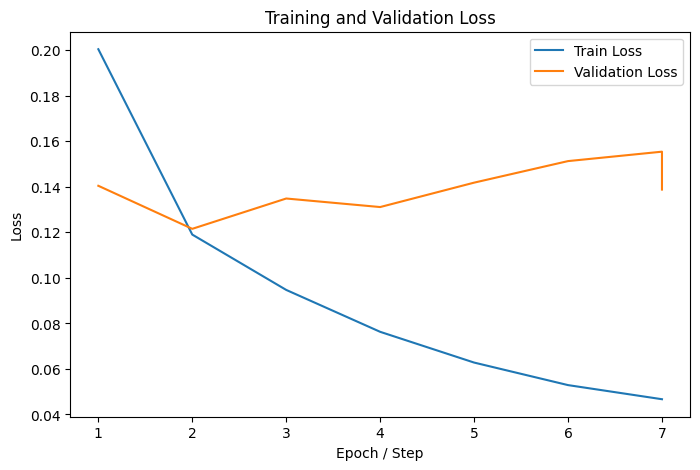

In [35]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(val_epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch / Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [38]:
import shutil

In [39]:
shutil.make_archive('bert_per_org', 'zip', './bert_per_org')

from IPython.display import FileLink
FileLink(r'bert_per_org.zip')

/kaggle/working/bert_per_org.zip